In [11]:
# =========================
#  Environment Setup
# =========================
!pip install --upgrade pip \
&& pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com \
&& pip install --upgrade optimum[neuronx] \
&& pip install --upgrade optimum-neuron neuronx-cc transformers_neuronx neuronx_distributed neuronx-cc==2.* neuronx-distributed-inference transformers torch-neuronx accelerate diffusers triton protobuf \
&& pip install faiss-cpu numpy scikit-learn pandas matplotlib seaborn
print("✅ Environment setup complete!")

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Writing to /root/.config/pip/pip.conf
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached optimum-1.24.0-py3-none-any.whl.metadata (21 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
INFO: pip is looking at multiple versions of optimum-neuron to determine which version is compatible with other requirements. This could take a while.
  Using cached optimum_neuron-0.0.28-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.27-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.26-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.25-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.24-py3-none-any.whl.metadata (15 kB)
  Using cached transformers-4.41.1-py3-none-any.whl.metadata (43 kB)
  Using cached optimum_neuron-0.0.23-py3-none-any.whl.metadata (14 kB)
  Using cached 

In [12]:
! export BOOKS_DF_DS="books_df.pkl"; export NROWS="1000" \
&& python cell_load_books.py

Books_rating.csv already exists locally. Skipping download.
✅ Books dataset loaded & saved in books_df.pkl.


In [15]:
# If you haven't compiled the model and pushed to huggingface run the following steps with the models you like to explore. 
# This example shows the Llama 3.2 1B. Look for more yaml files in the repo and execute the same. 
! cat nxd_vllm_1b.yaml \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_1B" \
&& git config --global credential.helper store \
&& export HUGGINGFACE_TOKEN=hf_ADD_YOUR_HF \
&& python cell_compile_vllm.py nxd_vllm_1b.yaml

model: "meta-llama/Llama-3.1-8B-Instruct"
tensor_parallel_size: 8
max_num_seqs: 1
max_model_len: 2048
override_neuron_config:
  skip_warmup: true
device: "neuron"
INFO 04-18 21:35:02 __init__.py:198] Automatically detected platform neuron.
INFO 04-18 21:35:10 config.py:542] This model supports multiple tasks: {'classify', 'score', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
INFO 04-18 21:35:10 config.py:1403] Defaulting to use uni for distributed inference
WARNING 04-18 21:35:10 config.py:678] Async output processing is not supported on the current platform type neuron.
INFO 04-18 21:35:10 llm_engine.py:234] Initializing a V0 LLM engine (v0.1.dev4531+g0107537) with config: model='meta-llama/Llama-3.1-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.1-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={'skip_warmup': True}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_le

In [21]:
# If you haven't compiled the embedders models and pushed to huggingface run the following steps with the embedders you like to explore.
# This example shows how to compile the google/t5-v1_1-base and we used similar cells with google/t5-v1_1-large and google/t5-v1_1-xl
!export COMPILED_MODEL_ID="yahavb/t5-v1_1-base" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export MAX_SEQ_LEN=2048 \
&& export TP_DEGREE=2 \
&& export HUGGINGFACE_TOKEN=hf_ADD_YOUR_HF \
&& git config --global credential.helper store \
&& python cell_compile_t5.py 

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you unde

In [23]:
# expand user interests with LLM - Llama 3.2 1B deployed with vLLM using NxDI. 
# Run this cell with all the LLMs you would like to explore. Here we show expanded interest using Llama 3.2 1B model but we also run
# it with Deepseek R1 8B and 70B Llama distilled models. 
! export BOOKS_DF_DS_EXP_INTEREST="expanded_interest_books_nxd_vllm_1b.pkl" \
&& export HUGGINGFACE_TOKEN=hf_ADD_YOUR_HF \
&& git config --global credential.helper store \
&& export BOOKS_DF_DS="books_df.pkl" \
&& export MODEL_ID="yahavb/nxd_vllm_1b" \
&& python cell_expand_interest_llm.py nxd_vllm_1b.yaml

INFO 04-18 21:53:50 __init__.py:198] Automatically detected platform neuron.
Loaded the dataset books_df.pkl
INFO 04-18 21:54:05 config.py:542] This model supports multiple tasks: {'reward', 'classify', 'embed', 'generate', 'score'}. Defaulting to 'generate'.
INFO 04-18 21:54:05 config.py:1403] Defaulting to use uni for distributed inference
WARNING 04-18 21:54:05 config.py:678] Async output processing is not supported on the current platform type neuron.
INFO 04-18 21:54:05 llm_engine.py:234] Initializing a V0 LLM engine (v0.1.dev4531+g0107537) with config: model='meta-llama/Llama-3.2-1B', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={'skip_warmup': True}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, en

In [24]:
import pandas as pd
df = pd.read_pickle('expanded_interest_books_nxd_vllm_1b.pkl')
print(df.head(2))

           Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

  review/helpfulness  review/score  review/time  \
0                7/7           4.0    940636800   
1              10/10           5.0   1095724800   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                   expanded_interest  \
0                                                      
1  ads while being inside a public library buildi...   

                                        t5_embedding  
0  [-0.006195068359375, 0.08447265625, -0.0810546...  
1  [-0.0111083984375, 0.0380859375, -0.0588378906...  


In [25]:
## generate T5-based embeddings and FAISS index from the expanded lists. This example uses meta-llama/Llama-3.2-1B and google/t5-v1_1-base
## for the T5-based embeddings, the embeddings are being converted to FAISS (Facebook AI Similarity Search) index. 
## It is a vector search engine that allows fast nearest-neighbor retrieval. It stores T5-based embeddings computed from expanded interests. Each book review is transformed into a vector.
## Used to find books closest in meaning to a user's expanded interest.
!export BOOKS_DF_DS_EXP_INTEREST="expanded_interest_books_nxd_vllm_1b.pkl" \
&& export BOOKS_DF_FAISS_IDX="expanded_interest_books_nxd_vllm_1b_t5_base_faiss.index" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export COMPILED_MODEL_ID="yahavb/t5-v1_1-base" \
&& export MAX_SEQ_LEN=2048 \
&& python cell_t5_embeddings.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
Loaded dataset path: test_interest_books_nxd_vllm_1b.pkl
Fetching 32 files:   0%|                                 | 0/32 [00:00<?, ?it/s]
tp_0.pt:   0%|                                       | 0.00/183M [00:00<?, ?B/s]

tp_1.pt:   0%|                                       | 0.00/183M [00:00<?, ?B/s]
tp_0.pt:   6%|█▋  

In [ ]:
## By now we created the similarity index with the user expanded interest for Llama 3.2 1B and google/t5-v1_1-base. 
## To complete the indexes population run expand_interest_generate_faiss_index.sh script that will compile the models and generate 
## the indexes for DeepSeek R1 8B and 70B with t5-v1_1-large and t5-v1_1-xl. 

Discovered FAISS index files:
3b_t5_large: expanded_interest_books_nxd_vllm_3b_t5_large_faiss.index
8b_t5_large: expanded_interest_books_nxd_vllm_8b_t5_large_faiss.index
3b_t5_xl: expanded_interest_books_nxd_vllm_3b_t5_xl_faiss.index
70b_t5_base: expanded_interest_books_nxd_vllm_70b_t5_base_faiss.index
1b_t5_large: expanded_interest_books_nxd_vllm_1b_t5_large_faiss.index
8b_t5_base: expanded_interest_books_nxd_vllm_8b_t5_base_faiss.index
70b_t5_xl: expanded_interest_books_nxd_vllm_70b_t5_xl_faiss.index
1b_t5_base: expanded_interest_books_nxd_vllm_1b_t5_base_faiss.index
3b_t5_base: expanded_interest_books_nxd_vllm_3b_t5_base_faiss.index
8b_t5_xl: expanded_interest_books_nxd_vllm_8b_t5_xl_faiss.index
1b_t5_xl: expanded_interest_books_nxd_vllm_1b_t5_xl_faiss.index
70b_t5_large: expanded_interest_books_nxd_vllm_70b_t5_large_faiss.index

Analyzing FAISS indices:

Index '3b_t5_large': Dimension = 1024, Total Vectors = 100000
Sample query vector from '3b_t5_large' (first 5 dims): [0.00325331 

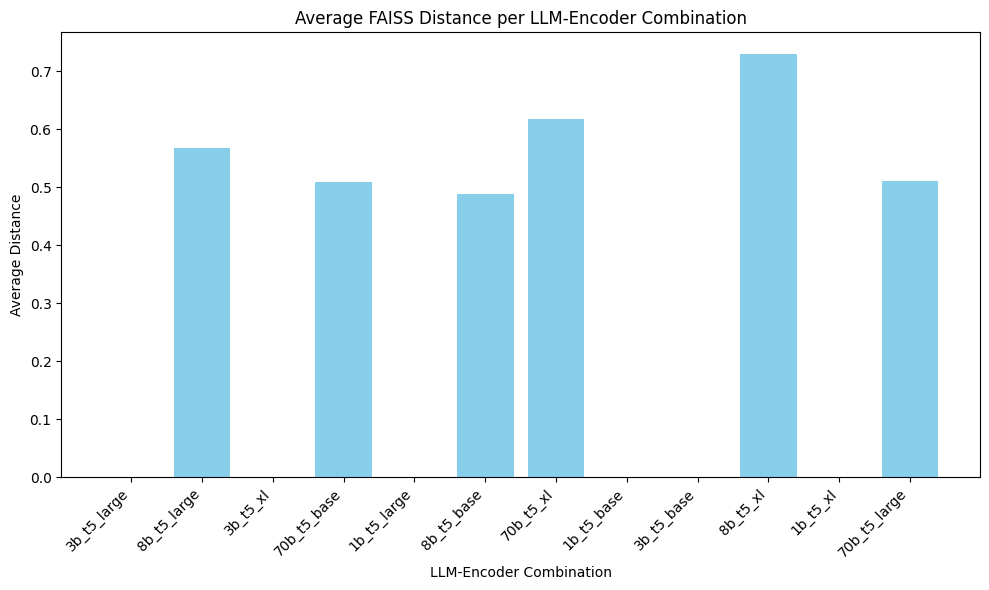

In [7]:


import os
import glob
import numpy as np
import faiss
import matplotlib.pyplot as plt

# Discover all .index files in the current directory
index_files = {}
for filepath in glob.glob("*.index"):
    base = os.path.basename(filepath)
    # Remove common prefixes; adjust if necessary based on your filename conventions.
    if base.startswith("expanded_interest_books_nxd_vlm_"):
         key = base[len("expanded_interest_books_nxd_vlm_"):]
    elif base.startswith("expanded_interest_books_nxd_vllm_"):
         key = base[len("expanded_interest_books_nxd_vllm_"):]
    else:
         key = base
    # Remove the trailing suffix "_faiss.index"
    if key.endswith("_faiss.index"):
         key = key[:-len("_faiss.index")]
    index_files[key] = filepath

if not index_files:
    print("No FAISS index files discovered in the current directory.")
else:
    print("Discovered FAISS index files:")
    for k, v in index_files.items():
        print(f"{k}: {v}")

top_k = 10  # Number of neighbors to retrieve

avg_dists = {}
dimensions = {}

print("\nAnalyzing FAISS indices:\n")
for key, filepath in index_files.items():
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        continue

    # Load the FAISS index
    index = faiss.read_index(filepath)
    dimensions[key] = index.d
    print(f"Index '{key}': Dimension = {index.d}, Total Vectors = {index.ntotal}")

    if index.ntotal == 0:
        print(f"Index '{key}' is empty. Skipping query.\n")
        continue

    # Reconstruct the first vector from the index to use it as a query.
    query = np.zeros((1, index.d), dtype=np.float32)
    index.reconstruct_n(0, 1, query)

    # Print a snippet of the query vector for debugging.
    print(f"Sample query vector from '{key}' (first 5 dims): {query[0][:5]}")

    # Execute a k-NN search using the query vector.
    distances, indices = index.search(query, top_k)
    print(f"Raw distances for '{key}': {distances}")
    print(f"Raw indices for '{key}': {indices}")

    avg_distance = float(distances.mean())
    avg_dists[key] = avg_distance
    print(f"    Top-{top_k} average distance = {avg_distance}\n")

# Debug: Print computed average distances.
print("Computed average distances:")
for k, v in avg_dists.items():
    print(f"{k}: {v}")

# Plotting: Create a bar chart comparing the average FAISS distances
if not avg_dists:
    print("No valid average distances computed. Check that your FAISS index files are not empty.")
else:
    keys = list(avg_dists.keys())
    avg_values = [avg_dists[k] for k in keys]

    plt.figure(figsize=(10, 6))
    plt.bar(keys, avg_values, color='skyblue')
    plt.title("Average FAISS Distance per LLM-Encoder Combination")
    plt.xlabel("LLM-Encoder Combination")
    plt.ylabel("Average Distance")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


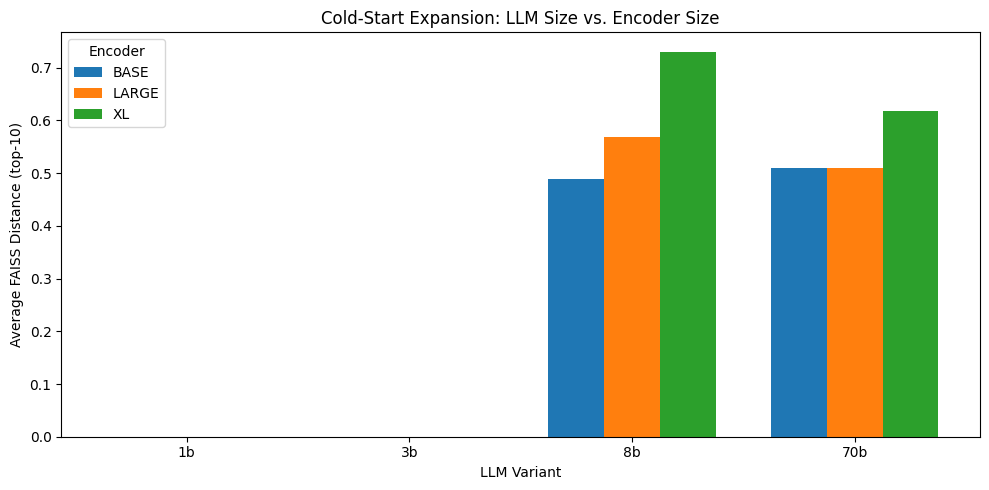

In [9]:
import os
import numpy as np
import faiss
import matplotlib.pyplot as plt

def avg_faiss_distance(llm_variant: str, encoder_variant: str, top_k: int = 5) -> float:
    """
    Load the FAISS index for a given LLM size and encoder size,
    reconstruct the 0th vector as a query, and return its mean top-k distance.
    """
    index_path = f"expanded_interest_books_nxd_vllm_{llm_variant}_{encoder_variant}_faiss.index"
    if not os.path.exists(index_path):
        raise FileNotFoundError(f"Index not found: {index_path}")
    idx = faiss.read_index(index_path)
    # reconstruct the first vector
    q = np.zeros((1, idx.d), dtype="float32")
    idx.reconstruct_n(0, 1, q)
    D, _ = idx.search(q, top_k)
    return float(D.mean())

# Define your experiment grid:
llm_variants      = ["1b", "3b", "8b", "70b"]
encoder_variants  = ["t5_base", "t5_large", "t5_xl"]
top_k             = 10

# Collect results in a matrix [len(llm) x len(enc)]
results = np.zeros((len(llm_variants), len(encoder_variants)), dtype=float)

for i, llm in enumerate(llm_variants):
    for j, enc in enumerate(encoder_variants):
        try:
            results[i, j] = avg_faiss_distance(llm, enc, top_k=top_k)
        except FileNotFoundError:
            results[i, j] = np.nan  # or skip / warn

# Now plot a grouped bar chart:
x = np.arange(len(llm_variants))  # one tick per LLM variant
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))
for j, enc in enumerate(encoder_variants):
    ax.bar(x + j*width, results[:, j], width, label=enc.replace("t5_", "").upper())

ax.set_xticks(x + width)
ax.set_xticklabels(llm_variants)
ax.set_xlabel("LLM Variant")
ax.set_ylabel(f"Average FAISS Distance (top-{top_k})")
ax.set_title("Cold‑Start Expansion: LLM Size vs. Encoder Size")
ax.legend(title="Encoder")
plt.tight_layout()
plt.show()



Overlap among encoders for LLM=1b:
  t5_base vs t5_large: 3/5 (60.0%)
  t5_base vs t5_xl: 3/5 (60.0%)
  t5_large vs t5_xl: 3/5 (60.0%)

Overlap among encoders for LLM=3b:
  t5_base vs t5_large: 5/5 (100.0%)
  t5_base vs t5_xl: 5/5 (100.0%)
  t5_large vs t5_xl: 5/5 (100.0%)

Overlap among encoders for LLM=8b:
  t5_base vs t5_large: 2/5 (40.0%)
  t5_base vs t5_xl: 2/5 (40.0%)
  t5_large vs t5_xl: 1/5 (20.0%)

Overlap among encoders for LLM=70b:
  t5_base vs t5_large: 2/5 (40.0%)
  t5_base vs t5_xl: 1/5 (20.0%)
  t5_large vs t5_xl: 1/5 (20.0%)

Overlap among LLMs for Encoder=t5_base:
  1b vs 3b: 2/5 (40.0%)
  1b vs 8b: 1/5 (20.0%)
  1b vs 70b: 1/5 (20.0%)
  3b vs 8b: 1/5 (20.0%)
  3b vs 70b: 1/5 (20.0%)
  8b vs 70b: 2/5 (40.0%)

Overlap among LLMs for Encoder=t5_large:
  1b vs 3b: 2/5 (40.0%)
  1b vs 8b: 1/5 (20.0%)
  1b vs 70b: 1/5 (20.0%)
  3b vs 8b: 1/5 (20.0%)
  3b vs 70b: 1/5 (20.0%)
  8b vs 70b: 1/5 (20.0%)

Overlap among LLMs for Encoder=t5_xl:
  1b vs 3b: 2/5 (40.0%)
  1b vs 8b: 

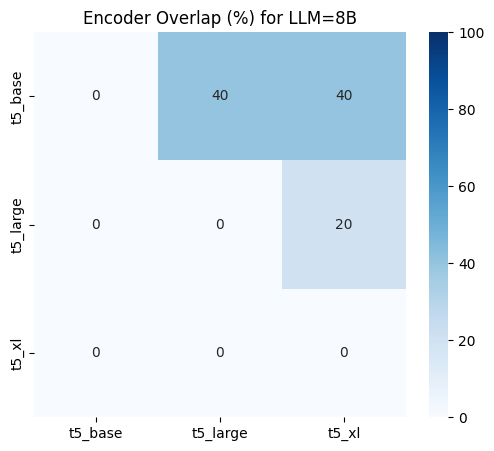

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

def recommend_books(user_reviews, llm_variant, encoder_variant, top_k=5):
    """
    Returns a set of top-k Titles recommended by the given llm+encoder combo.
    """
    idx_path = f"expanded_interest_books_nxd_vllm_{llm_variant}_{encoder_variant}_faiss.index"
    df_path  = f"expanded_interest_books_nxd_vllm_{llm_variant}.pkl"
    df = pd.read_pickle(df_path)
    idx = faiss.read_index(idx_path)
    # reconstruct row 0 as query
    q = np.zeros((1, idx.d), dtype="float32")
    idx.reconstruct_n(0, 1, q)
    D, I = idx.search(q, top_k)
    return set(df.iloc[I[0]]["Title"].tolist())

llm_variants     = ["1b", "3b", "8b", "70b"]
encoder_variants = ["t5_base", "t5_large", "t5_xl"]
top_k            = 5

# 1) Overlap between encoders for each LLM
for llm in llm_variants:
    print(f"\nOverlap among encoders for LLM={llm}:")
    for e1, e2 in combinations(encoder_variants, 2):
        set1 = recommend_books("", llm, e1, top_k)
        set2 = recommend_books("", llm, e2, top_k)
        common = set1 & set2
        pct = 100 * len(common) / top_k
        print(f"  {e1} vs {e2}: {len(common)}/{top_k} ({pct:.1f}%)")

# 2) Overlap between LLMs for each encoder
for enc in encoder_variants:
    print(f"\nOverlap among LLMs for Encoder={enc}:")
    for m1, m2 in combinations(llm_variants, 2):
        set1 = recommend_books("", m1, enc, top_k)
        set2 = recommend_books("", m2, enc, top_k)
        common = set1 & set2
        pct = 100 * len(common) / top_k
        print(f"  {m1} vs {m2}: {len(common)}/{top_k} ({pct:.1f}%)")

# 3) Optional: plot a heatmap of encoder-overlaps for one LLM
import seaborn as sns

data = []
labels = encoder_variants
for e1, e2 in combinations(encoder_variants, 2):
    data.append([
        100 * len(recommend_books("", llm_variants[2], e1, top_k) &
                 recommend_books("", llm_variants[2], e2, top_k)) / top_k
    ])
heat = np.zeros((len(labels), len(labels)))
for i, e1 in enumerate(labels):
    for j, e2 in enumerate(labels):
        if i < j:
            heat[i,j] = 100 * len(recommend_books("", llm_variants[2], e1, top_k) &
                                  recommend_books("", llm_variants[2], e2, top_k)) / top_k

plt.figure(figsize=(6,5))
sns.heatmap(heat, xticklabels=labels, yticklabels=labels, annot=True, cmap="Blues", vmin=0, vmax=100)
plt.title(f"Encoder Overlap (%) for LLM={llm_variants[2].upper()}")
plt.show()


In [26]:
base_recs  = recommend_books("", "8b", "t5_base",  top_k=5)
large_recs = recommend_books("", "8b", "t5_large", top_k=5)

print("BASE recs: ",  base_recs)
print("LARGE recs:", large_recs)
print("Overlap:   ", base_recs & large_recs)


BASE recs:  {'The Hobbitt, or there and back again; illustrated by the author.', 'Newcomer Program Program (Prentice Hall Regents ESL)', 'Its Only Art If Its Well Hung!', 'The Secret of Red Gate Farm (Nancy Drew, Book 6)', 'Cruel and Unusual (G K Hall Large Print Book Series (Cloth))'}
LARGE recs: {'God was in this place & I, i did not know: Finding self, spirituality, and ultimate meaning', 'Its Only Art If Its Well Hung!', 'Twenty Thousand Leagues Under the Sea (Caxton Edition)', 'Cruel and Unusual (G K Hall Large Print Book Series (Cloth))', 'The witch of blackbird pond (A Dell yearling book)'}
Overlap:    {'Its Only Art If Its Well Hung!', 'Cruel and Unusual (G K Hall Large Print Book Series (Cloth))'}
